# Compare the interactions of CRPropa and LIVpropa

CRPropa's `EMPairProduction` and LIVpropa's `PairProductionLIV` should be the same for order 0 LIV. 

In [41]:
import sys
sys.path.append('../build/')

from crpropa import *
from livpropa import *

### Defining the simulation parameters

In [42]:
# general parameters
dsrc = redshift2ComovingDistance(0.14)
electrons = True
photons = True
thinning = 0.9999 # if 0, no thinning; speeds up the simulations considerably
cmb = CMB()
ebl = IRB_Gilmore12()
crb = URB_Nitu21()

# define source
source = Source()
source.add(SourcePosition(Vector3d(dsrc, 0, 0)))
source.add(SourceRedshift1D())
source.add(SourceParticleType(22))
source.add(SourcePowerLawSpectrum(1 * GeV, 100 * TeV, -1)) # intrinsic source spectrum

# output files
outputFileCRPropa = 'sim-test-crpropa.txt'
outputFileLIVpropa = 'sim-test-livpropa.txt'

# simulation statistic
nEvents = 20000


### Running CRPropa simulation

In [43]:

simCRPropa = ModuleList()
simCRPropa.add(SimplePropagation())
simCRPropa.add(Redshift())
simCRPropa.add(EMPairProduction(cmb, electrons, thinning))
simCRPropa.add(EMPairProduction(ebl, electrons, thinning))
simCRPropa.add(EMPairProduction(crb, electrons, thinning))
# simCRPropa.add(EMInverseComptonScattering(cmb, photons, thinning))
# simCRPropa.add(EMInverseComptonScattering(ebl, photons, thinning))
simCRPropa.add(MinimumEnergy(1 * GeV))

obsCRPropa = Observer()
obsCRPropa.add(Observer1D())
outputCRPropa = TextOutput(outputFileCRPropa, Output.Event1D)
outputCRPropa.setEnergyScale(eV)
outputCRPropa.enable(outputCRPropa.WeightColumn) 
outputCRPropa.disable(outputCRPropa.CandidateTagColumn) 
obsCRPropa.onDetection(outputCRPropa)

simCRPropa.add(obsCRPropa)
simCRPropa.setShowProgress()
simCRPropa.run(source, nEvents, True)
outputCRPropa.close()

crpropa::ModuleList: Number of Threads: 10
Run ModuleList
  Started Sat May 20 18:03:54 2023 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Sat May 20 18:03:54 2023


### Running LIVpropa simulation

In [44]:

liv = LorentzSymmetry(1.22e28 * eV, 0, 1.)

simLIVpropa = ModuleList()
simLIVpropa.add(SimplePropagation())
simLIVpropa.add(Redshift())
simLIVpropa.add(PairProductionLIV(cmb, liv, electrons, thinning))
simLIVpropa.add(PairProductionLIV(ebl, liv, electrons, thinning))
simLIVpropa.add(PairProductionLIV(crb, liv, electrons, thinning))
# simCRPropa.add(EMInverseComptonScattering(cmb, photons, thinning))
# simCRPropa.add(EMInverseComptonScattering(ebl, photons, thinning))
simLIVpropa.add(MinimumEnergy(1 * GeV))

obsLIVpropa = Observer()
obsLIVpropa.add(Observer1D())
outputLIVpropa = TextOutput('sim-test-livpropa.txt', Output.Event1D)
outputLIVpropa.setEnergyScale(eV)
outputLIVpropa.enable(outputLIVpropa.WeightColumn) 
outputLIVpropa.disable(outputLIVpropa.CandidateTagColumn) 
obsLIVpropa.onDetection(outputLIVpropa)

simLIVpropa.add(obsLIVpropa)
simLIVpropa.setShowProgress()
simLIVpropa.run(source, nEvents, True)
outputLIVpropa.close()

crpropa::ModuleList: Number of Threads: 10
Run ModuleList
  Started Sat May 20 18:03:54 2023 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Sat May 20 18:03:54 2023


### Plot results for comparison

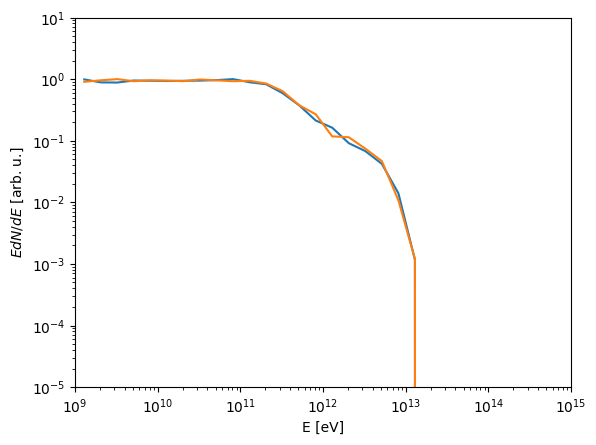

In [45]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def spectrum(filename, bins):
	# read file
	data = np.loadtxt(filename, comments = '#')
	idx = np.where(data[:, 1] == 22)
	energy = data[idx, 2]
	weight = data[idx, 5]

	binnedData, binEdges = np.histogram(energy, bins = bins, weights = weight)
	binCentres = binEdges[:-1] + ((binEdges[1 : ] - binEdges[ : -1]) / 2.)
	binnedData /= np.diff(binEdges) # dN/dE
	binnedData *= binCentres # E dN/dE

	return binCentres, binnedData

bins = np.logspace(9, 15, 31, endpoint = True)
x1, y1 = spectrum(outputFileCRPropa, bins)
x2, y2 = spectrum(outputFileLIVpropa, bins)
y1 /= np.amax(y1)
y2 /= np.amax(y2)

plt.xlim(1e9, 1e15)
plt.ylim(1e-5, 10.)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$E dN/dE$ [arb. u.]')
plt.xlabel('E [eV]')
plt.plot(x1, y1, label = 'CRPropa')
plt.plot(x2, y2, label = 'LIVpropa')
plt.show()
